<a href="https://colab.research.google.com/github/chefPony/genai-lab/blob/master/Text_Classification_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

From **chapter 6** of "Hands-On Generative AI with Transformers and Diffusion Models". The notebook mostly follows the book with just some minor changes. It provides a simple example of fine tuning a text classifier using a pretrained DistilBERT encoder model.

In [ ]:
%pip install datasets
%pip install transformers
%pip install evaluate
%pip install genaibook
%pip install --upgrade numpy

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("fancyzhx/ag_news")
raw_datasets

In [2]:
type(raw_datasets["train"])

datasets.arrow_dataset.Dataset

In [3]:
raw_train_dataset = raw_datasets["train"]
raw_test_dataset = raw_datasets["test"]

In [4]:
raw_train_dataset[0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [5]:
print(raw_train_dataset.features)

{'text': Value('string'), 'label': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])}


In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [7]:
?tokenizer

In [8]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=tokenizer.model_max_length, padding=True,
                   return_tensors="pt")

In [9]:
# 0 are for PAD tokens, note mask is 0 too
tokenize(raw_train_dataset[:2])

{'input_ids': tensor([[  101,  2813,  2358,  1012,  6468, 15020,  2067,  2046,  1996,  2304,
          1006, 26665,  1007, 26665,  1011,  2460,  1011, 19041,  1010,  2813,
          2395,  1005,  1055,  1040, 11101,  2989,  1032,  2316,  1997, 11087,
          1011, 22330,  8713,  2015,  1010,  2024,  3773,  2665,  2153,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101, 18431,  2571,  3504,  2646,  3293, 13395,  1006, 26665,  1007,
         26665,  1011,  2797,  5211,  3813, 18431,  2571,  2177,  1010,  1032,
          2029,  2038,  1037,  5891,  2005,  2437,  2092,  1011, 22313,  1998,
          5681,  1032,  6801,  3248,  1999,  1996,  3639,  3068,  1010,  2038,
          5168,  2872,  1032,  2049, 29475,  2006,  2178,  2112,  1997,  1996,
          3006,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize, batched=True)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  acc = accuracy.compute(references=labels, predictions=preds)["accuracy"]
  f1 = f1_score.compute(references=labels, predictions=preds,
                        average="weighted")["f1"]
  return {"accuracy": acc, "f1": f1}

In [14]:
accuracy.compute(references=[0, 0, 1, 1], predictions=[0,1,0,1])

{'accuracy': 0.5}

## Train Model

In [15]:
labels = raw_train_dataset.features["label"]

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from genaibook.core import get_device

device = get_device()

# The warning is raised because "distilbert-base-uncased" is an encoder model
# that only generates embedding. Hence the sequence classification head is
# untrained at this point. Nevertheless huggingface takes care of initializing it
# correctly.


model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=labels.num_classes).to(device)

In [17]:
from transformers import TrainingArguments

?TrainingArguments

In [21]:
batch_size = 32

training_args = TrainingArguments(
    "distilbert-finetune-example",
    push_to_hub=False,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # need to add this arg otherwise it will try to access wand.ai
    report_to="none"
)

In [22]:
from transformers import Trainer

shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset = small_split,
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer
    )

In [ ]:
trainer.train()

In [25]:
from transformers import pipeline

?pipeline

In [80]:
trainer.model.config.id2label = {k: l for k,l in enumerate(labels.names)}
pipe = pipeline(task="text-classification", model=trainer.model,
                tokenizer=tokenizer)

Device set to use cuda:0


In [81]:
sample_text = """Newly released google lens allows to look through walls"""

print(labels)
pipe.predict(sample_text)

ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'])


[{'label': 'Sci/Tech', 'score': 0.974265456199646}]

In [82]:
model_preds = pipe.predict(list(tokenized_datasets["test"]["text"]))

In [84]:
references = tokenized_datasets["test"]["label"]

samples = 3
texts = tokenized_datasets["test"]["text"][:3]

for text, ref, pred in zip(texts, references, model_preds):
  print(f"Predicted {pred["label"]}, Actual {labels.names[ref]}")
  print(text)
  print("=" * 25)

Predicted Business, Actual Business
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Predicted Sci/Tech, Actual Sci/Tech
The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.
Predicted Sci/Tech, Actual Sci/Tech
Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.


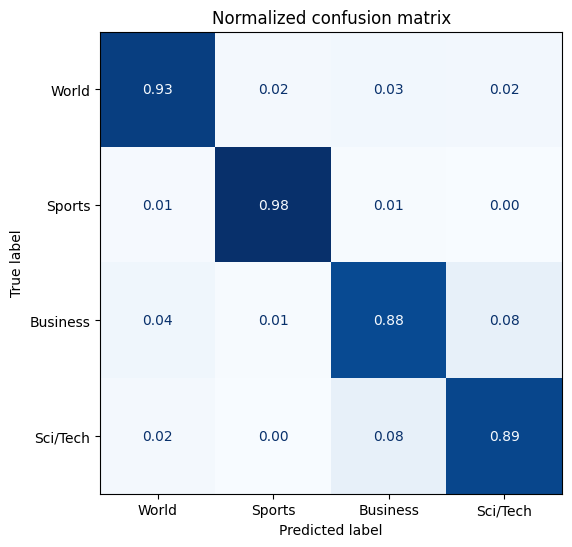

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

label_to_id = {n:k for k, n in enumerate(labels.names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(references=references, predictions=pred_labels,
                              normalize="true")["confusion_matrix"]

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()